# DSE 511: Individual Project 1
## Student Information
**Name:** Verónica G. Melesse Vergara \
**Email:** vmelesse@vols.utk.edu
## Summary
In this assignment you will perform a complete exploration of a dataset, and communicate what you find to us.
The minimum expectation is that you download the dataset, and provide a Jupyter notebook that clearly walking through the data, showing interesting features that suggest further experimentation and analysis. This means you will need to summarize and visualize the data. We suggest using Python for this, but if you are more comfortable with other languages such as R or Julia, you may use those as well. You will be graded based on reproducibility, clarity in presenting your findings, and depth of your analysis.
## The Data
The data you use will be financial data from a PKDD1999 Challenge. The data is described here (Ignore the references to KDD in the Task Description section): https://sorry.vse.cz/~berka/challenge/pkdd1999/berka.htm
These tables are prepared for you as a compressed sqlite database dump. Import it as follows:
• Download financial_sqlite.sql.zip
• Unzip this file (on Linux: unzip financial_sqlite.sql.zip).
• In bash run the following: cat financial_sqlite.sql | sqlite3
financial.db
This will create a sqlite database called financial.db with tables corresponding
to the description at the link above.
## Expectations for this project

In [1]:
# Needed for this notebook
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("whitegrid")
sns.set_context("poster")

### Download and import the data properly.

In [2]:
conn = sqlite3.connect("./financial.db")

In [3]:
# Create a cursor
cur = conn.cursor()

# Check if we can retrieve some information from the database
cur.execute("select * from account limit 1;")

# Get results
results = cur.fetchall()
print(results)

[(1, 18, 'POPLATEK MESICNE', '1995-03-24')]


### Use Jupyter to explore the dataset. You are encouraged to use Python but if you are more comfortable in R, Julia, or another language you may. However, like your other assignments, your submission should be in the form of an HTML export of a Jupyter notebook.

### Explain the high-level overview of what data is available. Show examples of rows in the tables and describe how the tables relate to one another.

The database contains financial data organized into eight tables: `account`, `card`, `client`, `disp`, `district`, `loan`, `order`, `trans`. We can query each table to obtain more information about the individual columns.

In [4]:
# View the tables in the database

cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cur.fetchall()
print(tables)

# View the columns in each table

for t in tables:
    print("\n\nTable: ",t[0])
    df = pd.read_sql_query("SELECT * FROM '" + t[0] + "' LIMIT 1;", conn)
    print(df.columns)

[('account',), ('card',), ('client',), ('disp',), ('district',), ('loan',), ('order',), ('trans',)]


Table:  account
Index(['account_id', 'district_id', 'frequency', 'date'], dtype='object')


Table:  card
Index(['card_id', 'disp_id', 'type', 'issued'], dtype='object')


Table:  client
Index(['client_id', 'gender', 'birth_date', 'district_id'], dtype='object')


Table:  disp
Index(['disp_id', 'client_id', 'account_id', 'type'], dtype='object')


Table:  district
Index(['district_id', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10',
       'A11', 'A12', 'A13', 'A14', 'A15', 'A16'],
      dtype='object')


Table:  loan
Index(['loan_id', 'account_id', 'date', 'amount', 'duration', 'payments',
       'status'],
      dtype='object')


Table:  order
Index(['order_id', 'account_id', 'bank_to', 'account_to', 'amount',
       'k_symbol'],
      dtype='object')


Table:  trans
Index(['trans_id', 'account_id', 'date', 'type', 'operation', 'amount',
       'balance', 'k_symbol', 'bank', 'a

We can also use the `pd.info()` function on a dataframe to obtain details on the query results. For example, as shown in the output below for the `account` table. 

In [5]:
df = pd.read_sql_query("SELECT COUNT(*) AS 'Number of Accounts' FROM account;", conn)
print("\n", df)

df = pd.read_sql_query("SELECT DISTINCT frequency AS 'Statement Frequency Types' FROM account;", conn)
print("\n",df)

df = pd.read_sql_query("SELECT frequency AS 'Statement Frequency', COUNT(*) AS 'Number of Accounts' FROM account GROUP BY frequency;", conn)
print("\n",df)

# Or using pandas only
df = pd.read_sql_query("SELECT * FROM account;", conn)
df.info()


    Number of Accounts
0                4500

   Statement Frequency Types
0          POPLATEK MESICNE
1            POPLATEK TYDNE
2        POPLATEK PO OBRATU

   Statement Frequency  Number of Accounts
0    POPLATEK MESICNE                4167
1  POPLATEK PO OBRATU                  93
2      POPLATEK TYDNE                 240
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   account_id   4500 non-null   int64 
 1   district_id  4500 non-null   int64 
 2   frequency    4500 non-null   object
 3   date         4500 non-null   object
dtypes: int64(2), object(2)
memory usage: 140.8+ KB


The `account` table includes characteristics about individual accounts including creation date and statement frequency. Using information from the table, we can quickly begin analyzing a wide range of static characteristics. 
The `account` table has `account_id` as its index that is used in `disp`, `loan`, `order`, and `trans` tables. The demographic information exists in the `client` and `disp` tables and is linked together via the `client_id` index. The `client` table also includes information about the district in the `district_id` column. This key is used to tie a client with a district and additional demographics information.

In Figure 1, for example, we find that the majority of the accounts are using monthly statements. In the figure, "POPLATEK MESICNE" represents monthly statement frequency, "POPLATEK PO OBRATU" represents weekly, and "POPLATEK TYDNE" represents transaction-based statements.

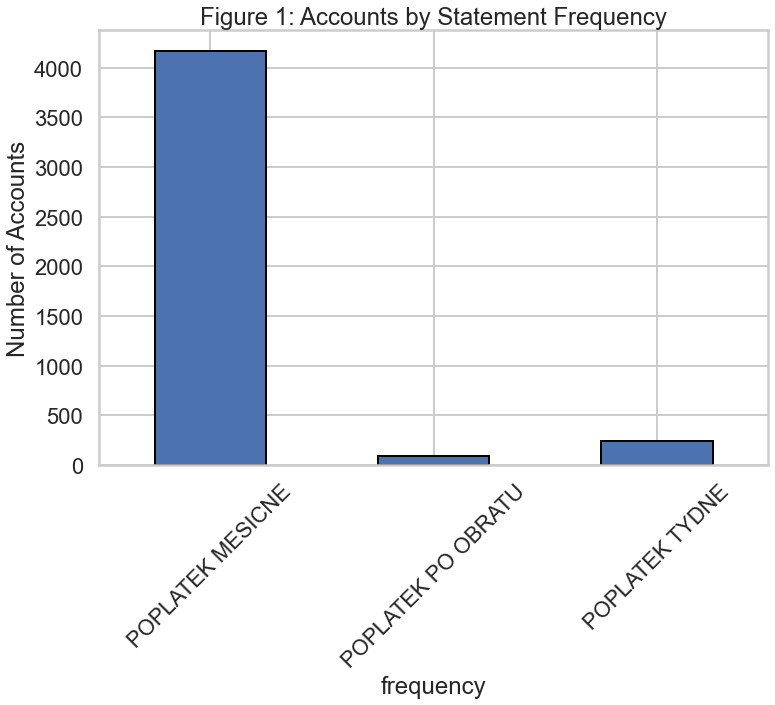

In [6]:
acct_freqs_count = df.groupby('frequency')[['account_id']].count()
ax = acct_freqs_count.plot.bar(title='Figure 1: Accounts by Statement Frequency',edgecolor='black',legend='',rot=45,figsize=(12,8))
ax.set_ylabel("Number of Accounts")
plt.show()

In Figure 2, we have gather accounts by creation date and can observe that the majority of accounts were created in 1993 and 1996 with a slow period between the two years and a decay in account creations after 1997.

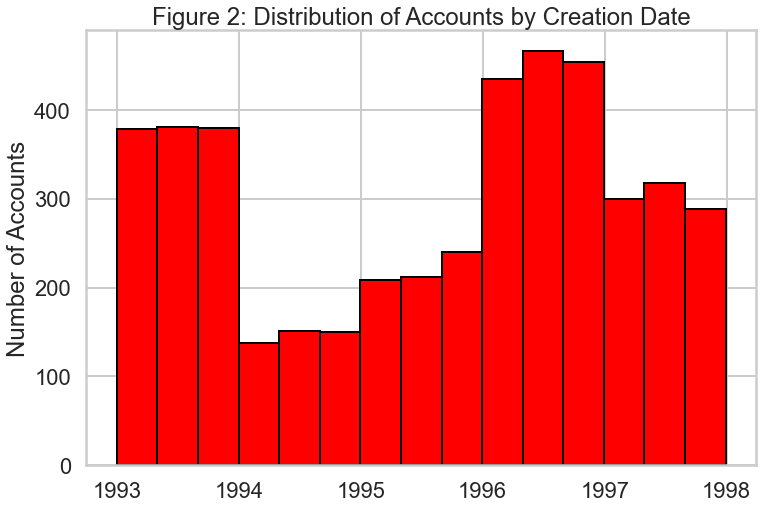

In [7]:
acct_dates = df['date'].astype("datetime64")
figdates = plt.figure(figsize=(12,8))
plt.hist(acct_dates,bins=15,color='red',edgecolor='black')
plt.ylabel("Number of Accounts")
plt.title("Figure 2: Distribution of Accounts by Creation Date")
plt.show()

### Summarize the data, through basic statistics/counting as well as visualization of particular quantities. This may involve combining information from multiple tables.

We will first get the account and transaction data from the database. To get a better idea of which banks see the majority of transactions, we group the transactions by bank. The results are shown in Figure 3. While there is some variability between the number of transactions collected per institution, the difference is small which can be useful when trying to understand features across institutions. The distribution of transactions across banks is relatively even.

In [8]:
dfaccount = pd.read_sql_query("SELECT * FROM account;",conn)
dfaccount.columns

Index(['account_id', 'district_id', 'frequency', 'date'], dtype='object')

In [9]:
dftrans = pd.read_sql_query("SELECT * FROM trans;", conn)
dftrans.columns

Index(['trans_id', 'account_id', 'date', 'type', 'operation', 'amount',
       'balance', 'k_symbol', 'bank', 'account'],
      dtype='object')

In [10]:
numtrans_by_bank = dftrans.groupby('bank')[['trans_id']].count()

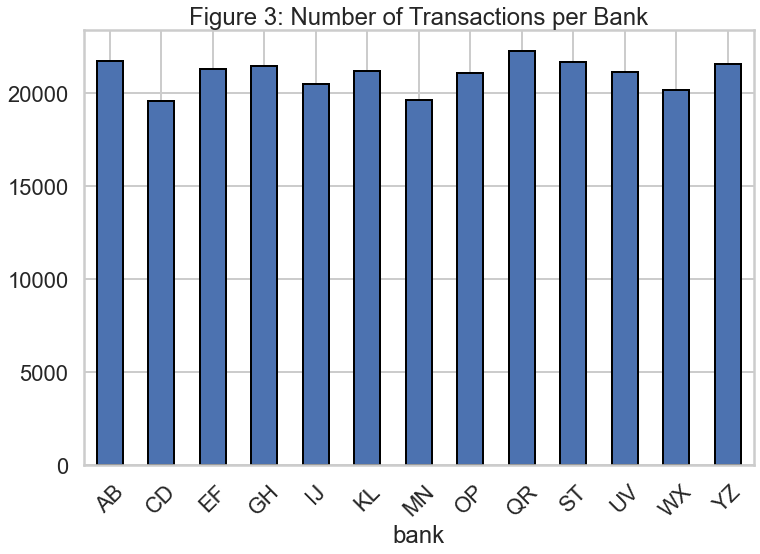

In [11]:
numtrans_by_bank.plot.bar(title='Figure 3: Number of Transactions per Bank',rot=45,legend='',figsize=(12,8),edgecolor='black')
plt.show()

Next, we looked at the `loan` table which has information on the creation of the loan, the total amount, the payments, the account associated with the loan, and the current status.

In [12]:
dfloan = pd.read_sql_query("SELECT * FROM loan;",conn)
dfloan.columns

Index(['loan_id', 'account_id', 'date', 'amount', 'duration', 'payments',
       'status'],
      dtype='object')

To confirm the information provided, we verified that each account only has at most a single loan.

In [13]:
dfloan.groupby('account_id')[['account_id']].count()

,account_id
account_id,
2,1
19,1
25,1
37,1
38,1
...,...
11327,1
11328,1
11349,1


Then, we grouped the loans by status to see how many of the loans issued were in good standing. 

In [14]:
dfloan.groupby('status')[['loan_id']].count()

,loan_id
status,
A,203
B,31
C,403
D,45


Given that the `loan` table doesn't provide any specifics on the clients, we also looked at the `client` table. This table has personal information on the client such as their gender, birth date, and district.

In [15]:
dfclient = pd.read_sql_query("SELECT * FROM client;",conn)
dfclient.columns

Index(['client_id', 'gender', 'birth_date', 'district_id'], dtype='object')

We found that clients are approximately 49% female and 51% male.

In [16]:
dfclient.groupby('gender').count()

,client_id,birth_date,district_id
gender,,,
F,2645,2645,2645
M,2724,2724,2724


Because only a subset of the clients are owners, we also included information from the disposition table. This table revealed that 4,500 owners exist in this database.

In [17]:
dfdisp = pd.read_sql_query("SELECT * FROM disp;",conn)
dfdisp.columns

Index(['disp_id', 'client_id', 'account_id', 'type'], dtype='object')

In [18]:
dfdisp.groupby('type')[['account_id']].count()

,account_id
type,
DISPONENT,869
OWNER,4500


To get more insights on the client's environment and circumstances, we also looked at the `district` table which includes information on the location of the client, unemployment and crime rates in the areas, and other demographic information.

In [19]:
dfdistrict = pd.read_sql_query("SELECT * FROM district;",conn)
dfdistrict.columns

Index(['district_id', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10',
       'A11', 'A12', 'A13', 'A14', 'A15', 'A16'],
      dtype='object')

Rather than investigating by district, we decided to look at specific regions. The following table summarizes all the regions and how many districts per region are present in the database.

In [20]:
dfdistrict.groupby('A3')[['district_id']].count()

,district_id
A3,
Prague,1
central Bohemia,12
east Bohemia,11
north Bohemia,10
north Moravia,11
south Bohemia,8
south Moravia,14
west Bohemia,10


To gather information about the loans as well as the clients and their environment, we combined the `loan`, `disp`, and `client` tables as follows.

In [21]:
loaninfo = pd.read_sql_query("SELECT * FROM loan JOIN disp ON loan.account_id = disp.account_id JOIN client on disp.client_id = client.client_id;",conn)
loaninfo

,loan_id,account_id,date,amount,duration,payments,status,disp_id,client_id,account_id,type,client_id,gender,birth_date,district_id
0,4959,2,1994-01-05,80952,24,3373,A,2,2,2,OWNER,2,M,1945-02-04,1
1,4959,2,1994-01-05,80952,24,3373,A,3,3,2,DISPONENT,3,F,1940-10-09,1
2,4961,19,1996-04-29,30276,12,2523,B,25,25,19,OWNER,25,F,1939-04-23,21
3,4962,25,1997-12-08,30276,12,2523,A,31,31,25,OWNER,31,M,1962-02-09,68
4,4967,37,1998-10-14,318480,60,5308,D,45,45,37,OWNER,45,M,1952-08-26,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
822,7295,11328,1998-07-18,280440,60,4674,C,13616,13924,11328,OWNER,13924,F,1952-09-09,54
823,7304,11349,1995-10-29,419880,60,6998,C,13647,13955,11349,OWNER,13955,F,1945-10-30,1
824,7304,11349,1995-10-29,419880,60,6998,C,13648,13956,11349,DISPONENT,13956,M,1943-04-06,1
825,7305,11359,1996-08-06,54024,12,4502,A,13660,13968,11359,OWNER,13968,M,1968-04-13,61


This combined dataframe allows us to gather the data in various ways. 
We first looked at how many account owners were female vs. male, and what status each of their individual loans had. The results are shown in Figure 4.

In [22]:
loan_bystatus_bygender = loaninfo[loaninfo.type == 'OWNER'].groupby(['status','gender'])['loan_id'].count()
loan_bystatus_bygender

status  gender
A       F         103
        M         100
B       F          17
        M          14
C       F         204
        M         199
D       F          24
        M          21
Name: loan_id, dtype: int64

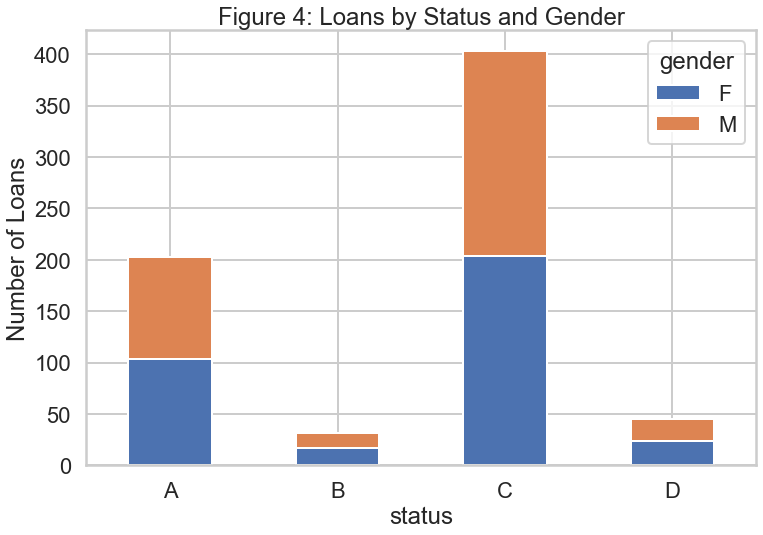

In [23]:
loan_status_gender = loaninfo[loaninfo.type == 'OWNER'].groupby(['status','gender'])['status'].count().unstack('gender')
loan_status_gender.plot(kind='bar', stacked=True,figsize=(12,8),title="Figure 4: Loans by Status and Gender",rot=0)
plt.ylabel("Number of Loans")
plt.show()

Figure 4 (above) shows the breakdown of loans by status and gender considering only account owners. The majority of loans in the records are currently active and in good standing (i.e. C status is "running contract, OK so far"). We also see that the number of loans issued to women are approximately the same as those issued to men.

Smallest loan amount =  4980
Largest loan amount =  590820
Average loan amount =  151410.1759530792


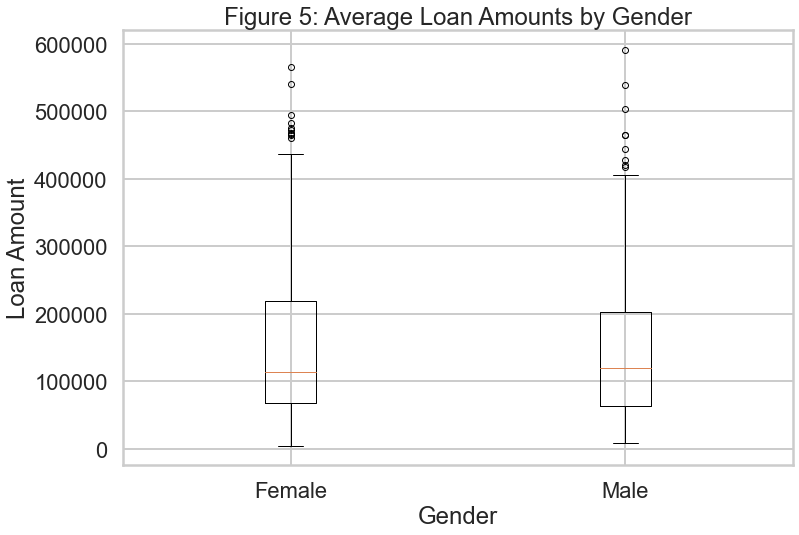

In [24]:
loaninfo_owners = loaninfo[loaninfo.type == "OWNER"]

maxloan = loaninfo_owners.amount.max()
minloan = loaninfo_owners.amount.min()
aveloan = loaninfo_owners.amount.mean()

print("Smallest loan amount = ",minloan)
print("Largest loan amount = ",maxloan)
print("Average loan amount = ",aveloan)

loan_owners_F = loaninfo_owners[loaninfo_owners.gender == "F"]
loan_owners_M = loaninfo_owners[loaninfo_owners.gender == "M"]

fig3 = plt.figure(figsize=(12,8))
plt.boxplot([loan_owners_F.amount, loan_owners_M.amount],labels=['Female','Male'])
plt.title('Figure 5: Average Loan Amounts by Gender')
plt.ylabel('Loan Amount')
plt.xlabel('Gender')
plt.show()

Another interesting aspect that we explored was the average loan amounts that banks have issued by gender. As shown in Figure 5 (above), the average loan amounts for female clients are slightly lower than that of male clients. In addition, the range of amounts for loans owned by a female client is greater.
From the data, we also found that the highest loan is over 590,820 and the smallest loan is 4,980, with an average loan amount of approximately 151,000.

Next, we included district information to understand if there was correlation for the status of a loan with the region.

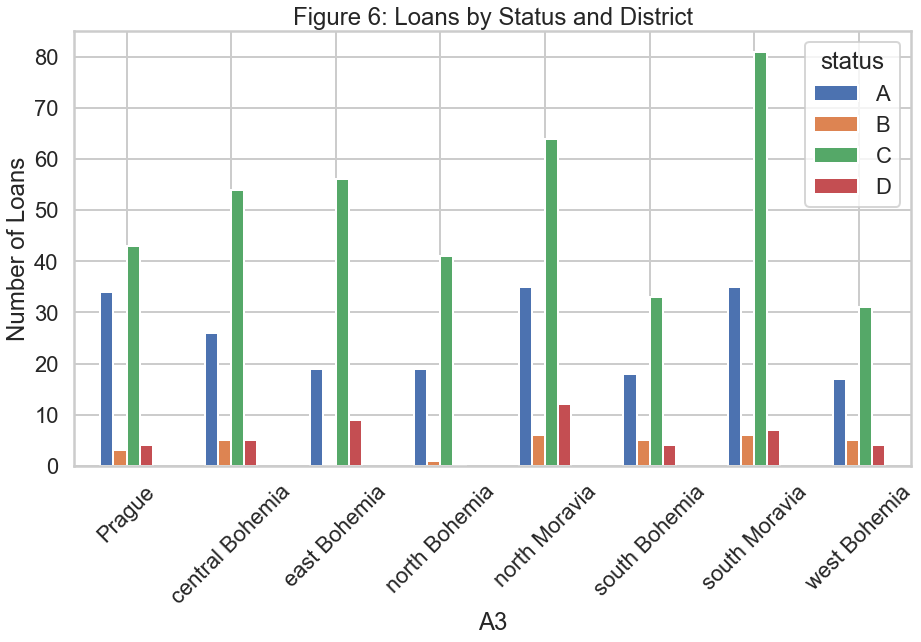

In [25]:
loandistrict = pd.read_sql_query("SELECT * FROM loan JOIN account ON loan.account_id = account.account_id JOIN district on account.district_id = district.district_id;",conn)
loan_status_district = loandistrict[['loan_id','status','district_id','A3']].groupby(['A3','status']).loan_id.count().unstack('status')
loan_status_district.plot.bar(figsize=(15,8),title="Figure 6: Loans by Status and District",rot=45)
plt.ylabel("Number of Loans")
plt.show()

As shown in Figure 6 (above), the majority of loans have been issued in the Moravia region (north and south). We can also see that the north Moravia district has the highest number of loans in default (status B and D).

The database also includes information on credit cards issued. In Figure 7, we show the distribution of the different types of credit cards issued.

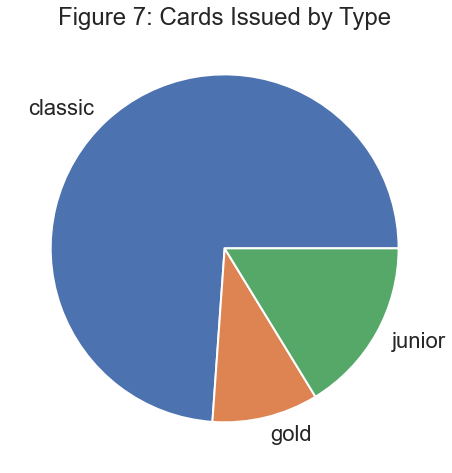

In [26]:
cardinfo_disp = pd.read_sql_query("SELECT card.card_id, card.type AS card_type, card.disp_id, disp.disp_id AS disp_disp_id, disp.type AS disp_type FROM card JOIN disp ON card.disp_id = disp.disp_id",conn)
cardinfo_disp.groupby('card_type').card_id.count().plot.pie(figsize=(15,8),title='Figure 7: Cards Issued by Type')
plt.ylabel('')
plt.show()

As shown in Figure 7 (above), the majority of credit cards issued belong to the "classic" type. 

The database also provides a table of transactions for all accounts. To understand the state of accounts when they were first created vs. in the most recent date, we looked at the `trans` table and grouped by account.

In [27]:
initialtransinfo = pd.read_sql_query("SELECT account_id, min(date) AS latest_date, balance FROM trans GROUP BY account_id;",conn)
initialtransinfo

,account_id,latest_date,balance
0,1,1995-03-24,1000
1,2,1993-02-26,1100
2,3,1997-07-07,1000
3,4,1996-02-21,800
4,5,1997-05-30,600
...,...,...,...
4495,11333,1994-05-26,500
4496,11349,1995-05-26,200
4497,11359,1994-10-01,1000
4498,11362,1995-10-14,1000


In [28]:
latest_transinfo = pd.read_sql_query("SELECT account_id, max(date) AS latest_date, balance FROM trans  GROUP BY account_id;",conn)
latest_transinfo

,account_id,latest_date,balance
0,1,1998-12-31,13467
1,2,1998-12-31,42628
2,3,1998-12-31,51096
3,4,1998-12-31,33721
4,5,1998-12-31,28088
...,...,...,...
4495,11333,1998-12-31,58203
4496,11349,1998-12-31,33978
4497,11359,1998-12-31,75200
4498,11362,1998-12-31,38531


Then, we selected the accounts with the highest current balance and lowest current balance.

In [29]:
top_accounts = pd.read_sql_query("SELECT account_id, max(date) AS latest_date, balance FROM trans  GROUP BY account_id ORDER BY balance DESC LIMIT 3;",conn)
top_accounts

,account_id,latest_date,balance
0,8856,1998-12-31,137830
1,3255,1998-12-18,127380
2,2245,1998-12-31,125280


In [30]:
bottom_accounts = pd.read_sql_query("SELECT account_id, max(date) AS latest_date, balance FROM trans  GROUP BY account_id ORDER BY balance ASC LIMIT 3;",conn)
bottom_accounts

,account_id,latest_date,balance
0,4356,1998-12-31,-25821
1,5092,1998-12-09,-20120
2,2305,1998-12-08,-18108


Finally, we use the information for the best and worst performers to plot their overall trend. The historical transaction data from these 6 accounts is shown in Figure 8.

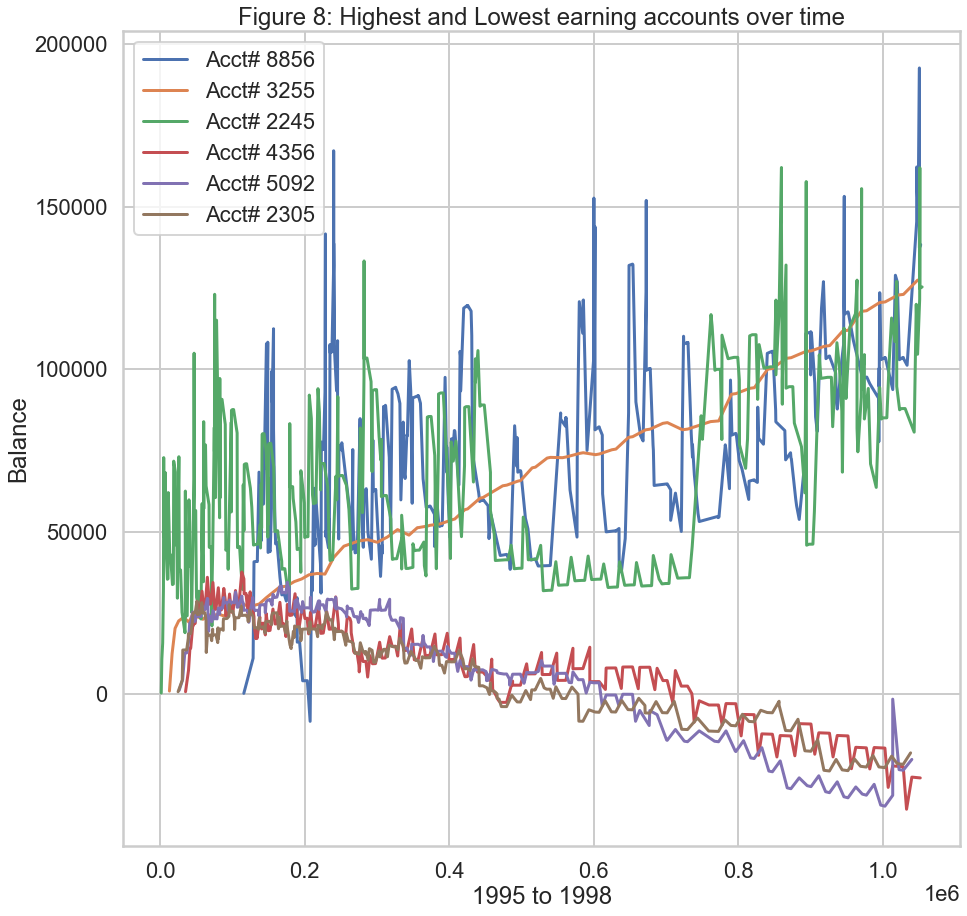

In [31]:
transinfo = pd.read_sql_query("SELECT account_id, date, balance FROM trans ORDER BY date;",conn)
transinfo

# Plot the top 3 highest earning accounts
for acctid in top_accounts['account_id']:
    transinfo[transinfo.account_id == acctid].balance.plot(figsize=(15,15),label="Acct# "+str(acctid))

# Plot the bottom 3 lowest earning accounts
for acctid in bottom_accounts['account_id']:
    transinfo[transinfo.account_id == acctid].balance.plot(figsize=(15,15),label="Acct# "+str(acctid))

plt.title("Figure 8: Highest and Lowest earning accounts over time")
plt.xlabel("1995 to 1998")
plt.ylabel("Balance")
plt.legend()
plt.show()

Lastly, we also looked at the orders from the highest and lowest performer accounts. We did not find any orders from the top performer and a single order was present for the worst performer. In this case the order was sent to bank AB and accounted for a lease payment. 

In [32]:
orderinfo = pd.read_sql_query('SELECT * FROM "order" WHERE account_id IN (4356,8856);',conn)
orderinfo

,order_id,account_id,bank_to,account_to,amount,k_symbol
0,35796,4356,AB,75449079,1003,LEASING


### Imagine you could collect further data from this bank. Suggest hypotheses for further experimentation, based on patterns you find in the present dataset.
It would be interesting to obtain information on the rates offered for both loans and credit cards across institutions and districts, as well as interests on individual savings accounts. This could help us further analyze the potential factors that countribute to a client defaulting on a loan.

It would also be interesting to compare the unemployment and crime data to performance of individual accounts. Currently, the database only includes data from 1995 and 1996 for both statistics.

### Do so clearly and reproducibly:
- Documentation is present/clear 
- Code is clearly organized/easy to understand. Comments exist where needed
- Data is explored thoroughly and important insights are summarized and easily digested by the reader.

In [33]:
# Close connection and cursor
cur.close()
conn.close()